## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

## Introduction

The finite-difference time-domain (FDTD) method employs finite differences as approximations to both the spatial and temporal derivatives that appear in Maxwell’s equations. For a function $f(x)$, the finite difference approximation of the derivative is given by
$$
\frac{df}{dx} = \frac{f(x+\frac{h}{2}) - f(x-\frac{h}{2})}{h} + O(h^2)
$$
where $h$ is the step size.

This is more accurate than the usual approximation of the derivative, which is
$$
\frac{df}{dx} = \frac{f(x+h) - f(x)}{h} + O(h)
$$

Let's look at a simple example. The function we'll use is $ f(x) = x^3 -2x^2 + x + 1 $. The derivative is $ \frac{df}{dx} = 3x^2 - 4x + 1 $.

In [1]:
def f(x):
    return x**3 - 2*x**2 + x

In [3]:
def df(x):
    return 3*x**2 - 4*x + 1

In [10]:
point = 2
hs = np.linspace(0.01, 0.2, 1000)
errors1 = np.zeros(len(hs))
errors2 = np.zeros(len(hs))

for i, h in enumerate(list(hs)):
    diff1 = np.abs((f(point + h) - f(point)) / h)
    diff2 = np.abs((f(point + h/2) - f(point - h/2)) / (h))
    actual_diff = df(point)
    errors1[i] = (diff1 - actual_diff)*100 / actual_diff
    errors2[i] = (diff2 - actual_diff)*100 / actual_diff

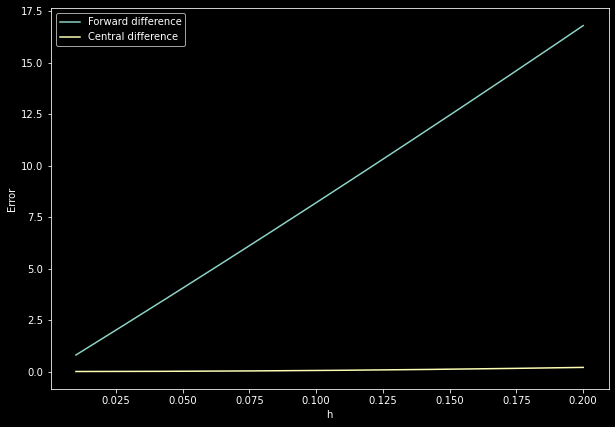

In [11]:
plt.figure(figsize=(10,7))
plt.plot(hs, errors1, label='Forward difference')
plt.plot(hs, errors2, label='Central difference')
plt.xlabel('h')
plt.ylabel('Error')
plt.legend()
plt.show();

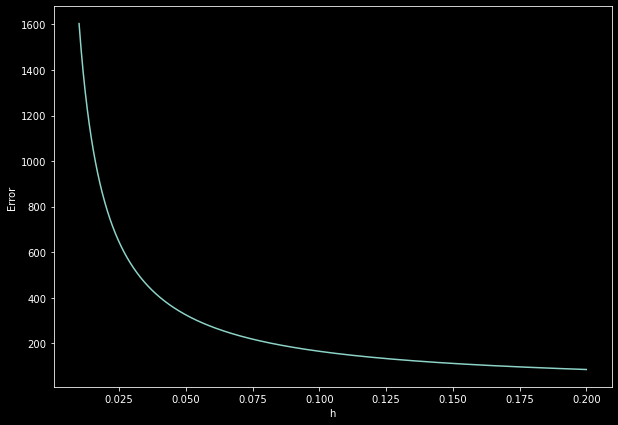

In [18]:
ratio = np.abs(errors1 / errors2)
plt.figure(figsize=(10,7))
plt.plot(hs, ratio)
plt.xlabel('h')
plt.ylabel('Error');

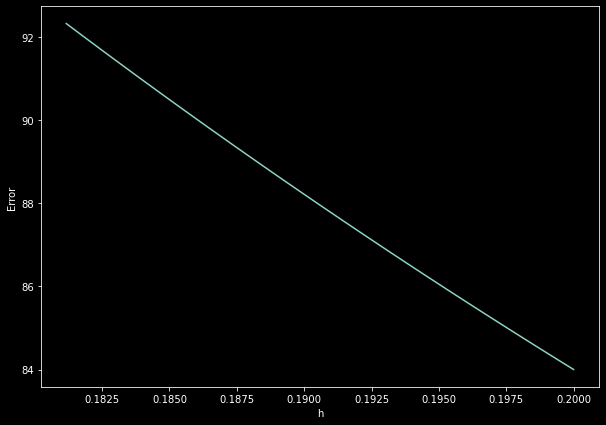

In [19]:
ratio = np.abs(errors1 / errors2)
plt.figure(figsize=(10,7))
plt.plot(hs[-100:], ratio[-100:])
plt.xlabel('h')
plt.ylabel('Error');

We can see that even at higher value of h, the central difference approximation is still over 50 times more accurate. While for smaller value of h, the accuracy is much better.

## The Yee Algorithm

The FDTD algorithm as first proposed by Kane Yee in 1966 employs second-order central differences. The algorithm can be summarized as follows:
1. Replace all the derivatives in Ampere’s and Faraday’s laws with finite differences. Discretize
space and time so that the electric and magnetic fields are staggered in both space and time.
2. Solve the resulting difference equations to obtain “update equations” that express the (unknown) future fields in terms of (known) past fields.
3. Evaluate the magnetic fields one time-step into the future so they are now known (effectively
they become past fields).
4. Evaluate the electric fields one time-step into the future so they are now known (effectively
they become past fields)

### Update Equations in 1D

The Faraday's law and Ampere's law in 1D are:
$$
\mu \frac{\partial H_y}{\partial t} = \frac{\partial E_z}{\partial x}\\
\epsilon \frac{\partial E_z}{\partial t} = \frac{\partial H_y}{\partial x}
$$

We'll use the first equation to advance the magnetic field in time and the second equation to advance the electric field. For this, we need to replace the derivatives with their finite differences. First step is to discretize space and time. We'll use
$$
E_z(x, t) = E_z(m\Delta _x, q\Delta _t) = E_z^q[m]\\
\text{and } H_y(x, t) = H_y(m\Delta _x, q\Delta _t) = H_y^q[m]
$$
where $m$ and $q$ are the spatial and temporal discretization steps.

Even though we are using a single dimension, time can be treated as a second dimension. This way, the electric and magnetic field nodes are staggered in time and space as the figure shows.

![](images/1_1.png)

When implementing FDTD algorithms we will see that the spatial indices are used as
array indices while the temporal index, which is essentially a global parameter, is not explicitly
specified for each field location

In the figure, assume that all the fields below the dahsed line are known. FDTD allows us to use this information to update the fields above the dashed line one step at a time.

Using the above notation, we can rewrite the update equations for the magnetic field using Faraday's law as:
$$
\frac{H_y^{q+\frac{1}{2}}[m+\frac{1}{2}] - H_y^{q-\frac{1}{2}}[m+\frac{1}{2}]}{\Delta _t} = \frac{E_z^q[m+1] - E_z^q[m]}{\Delta _x}
$$
Which, after solving gives:
$$
H_y^{q+\frac{1}{2}}[m+\frac{1}{2}] = H_y^{q-\frac{1}{2}}[m+\frac{1}{2}] +\frac{\Delta _t}{\mu \Delta _x}(E_z^q[m+1] - E_z^q[m])
$$

It shows that the future value
of $H_y$ depends on only its previous value and the neighboring electric fields. After applying this update rule to all the magnetic-field nodes, the dividing line between future and past values has advanced a
half time-step. The space-time grid thus appears as the figure below.

![](images/1_2.png)

Using the Ampere's law, the update rule for electric field is:
$$
E_z^{q+1}[m] =E_z^{q}[m]+\frac{\Delta _t}{\epsilon \Delta _x}(H_y^{q+\frac{1}{2}}[m+\frac{1}{2}] - H_y^{q+\frac{1}{2}}[m-\frac{1}{2}])
$$

Here, again, we see that the future value of $E_z$ depends on only its past value and the value of the
neighboring magnetic fields. After applying this update rule to all the electric-field nodes, the dividing line between future and past values has advanced a
half time-step. Thus after one update of E and H, the dividing line between past and future values has advanced a full time-step.

#### Courant Number

The ratio $x\Delta _x/\Delta _t$ is called the Courant number $S_c$. It is used to determine whether the time-step is too large for the numerical method to be stable. Note that energy can propagate a distance of $c\Delta _x$ in a time of $\Delta _t$. Hence, for starting, we'll use $S_c = 1$ .

Using the definition of the Courant number, we can write the contants in the update equation as:
$$
\frac{\Delta _t}{\epsilon \Delta _x} = \frac{\eta _0}{\epsilon _r}S_c\\
\frac{\Delta _t}{\mu \Delta _x} = \frac{1}{\mu _r \eta _0}S_c
$$

> Instead of treating time as a seperate dimension, we can assume that both the E and M fields are in single spatial dimension where the
electric and magnetic fields are offset a half spatial step from each other.

![](images/1_3.png)

## Implementing One-Dimensional FDTD Simulation

We start by discretizing the space and time. We'll create two arrays, one for the electric field and one for the magnetic field, with a size of $N$ nodes. For starting, we'll use $N = 200$.

In [2]:
N = 200
ez = np.zeros(N)
hy = np.zeros(N)

We have initialized the electric and magnetic fields to zero.

Note that the elements
in the `ez` and `hy` arrays are offset from each other by a half spatial step even though the array
values will be accessed using an integer index.

![](images/1_4.png)

It is arbitrary whether one initially wishes to think of an `ez` array element as existing to the
right or the left of an hy element with the same index. Here we will assume `ez` nodes are to
the left of `hy` nodes with the same index.

Using $S_c = 1$, the update equation, in code, is:

```
hy[m] = hy[m] + (ez[m+1] - ez[m]) / imp0
ez[m+1] = ez[m] + (hy[m] - hy[m-1]) * imp0
```

here `imp0` is the impedance of free space.

These two update equations, placed in appropriate loops, are the engines that drive an FDTD
simulation. However, there are a few obvious pieces missing from the puzzle before a useful
simulation can be performed. These missing pieces include
1. Nodes at start and at end have no neighbor in one side. eg. there is no `hy[-1]` node for the `ez[0]`.

This problem can be addressed by using boundary conditions.

2. Only a constant impedance is used so only a homogeneous medium can be modeled (in this
case free space).

This restriction can be removed by allowing the permittivity and permeability to change
from node to node.

3. As of yet there is no energy present in the field. If the fields are initially zero, they will
remain zero forever.

To remove this restriction, we can try  initializing the fields to a non-zero state. However, this
is cumbersome and typically not a good approach. Better solutions are to introduce energy via
either a hardwired source, an additive source, or a total-field/scattered-field (TFSF) boundary.

Let's take it all together two make a simulation of a wave propagating in free space.

In [3]:
N = 200
ez = np.zeros(N)
hy = np.zeros(N)
imp0 = 377.0
max_time = 2500
ezs = np.zeros((max_time, N))
hys = np.zeros((max_time, N))
for t in range(max_time):
    ez[0] = np.exp(-((t-30)**2)/100)
    # print(ez[0])
    for i in range(0, N-1):
        hy[i]= hy[i]+ (ez[i+1] - ez[i])/imp0
        # print(hy[i])
    for i in range(1, N):
        ez[i]= ez[i]+ (hy[i] - hy[i-1])*imp0
    ezs[t] = ez
    hys[t] = hy

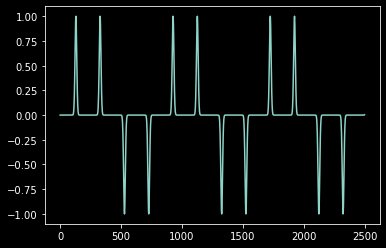

In [4]:
plt.plot(ezs[:, 100])

In [74]:
values =np.array([ezs[1], hys[1]])
values.shape

(2, 200)

### Animation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Time 50
Time 100
Time 150
Time 200
Time 250
Time 300
Time 350
Time 400
Time 450
Time 500
Time 550
Time 600
Time 650
Time 700
Time 750
Time 800
Time 850
Time 900
Time 950
Time 1000
Time 1050
Time 1100
Time 1150
Time 1200
Time 1250
Time 1300
Time 1350
Time 1400
Time 1450
Time 1500
Time 1550
Time 1600
Time 1650
Time 1700
Time 1750
Time 1800
Time 1850
Time 1900
Time 1950
Time 2000
Time 2050
Time 2100
Time 2150
Time 2200
Time 2250
Time 2300
Time 2350
Time 2400
Time 2450
Time 2500


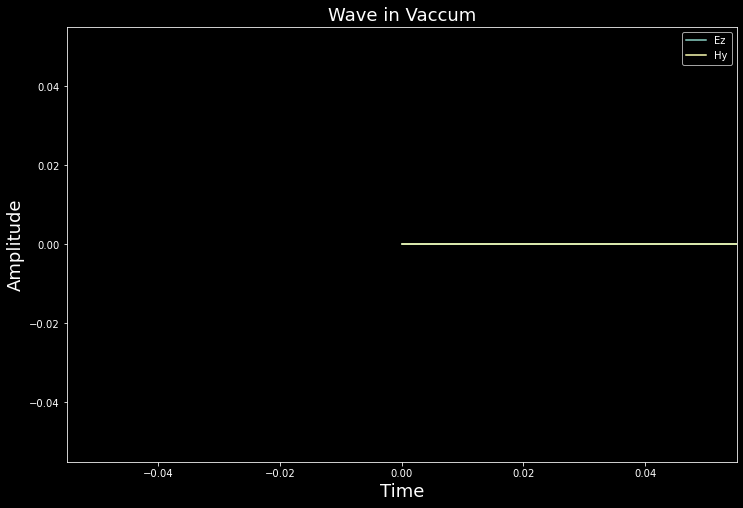

In [6]:
#Creating the Figure and Axes
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()

#Setting title and axes names
plt.title("Wave in Vaccum",
fontdict={'fontsize': 18})
plt.xlabel('Time', fontdict={'fontsize': 18})
plt.ylabel("Amplitude", fontdict={'fontsize': 18})

#Lines which are neede to animate
N = 2
lines = [plt.plot([], [])[0] for _ in range(N)]

#The init function
def init():
    #init lines
    for line in lines:
        line.set_data([], [])
    return lines

#Needed for adding legends
legend = plt.legend()

#The Animate function
def animate(i):
    values =np.array([ezs[i], hys[i]])

    # Plot the solution and the legends
    for j, line in enumerate(lines):
        line.set_data(range(200), values[j])
        if j==0:
            line.set_label('Ez')
        else:
            line.set_label('Hy')
    legend = plt.legend(loc='upper right')
    if (i+1)%50 == 0:
        print("Time", i+1)
    return lines + [legend]

#The animation
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=np.arange(0, 2500), interval=40, blit=True)

#Saving the Animation
anim.save('wave.mp4', writer='ffmpeg', dpi=200);